In [ ]:
'''
Anotações gerais:
Os dados possuem muitos exemplos de casos saudaveis e poucos com doença.
Erros na predição (baseline) -> Maior parte entre saudavel/doente. (Pode ter sido causado pela má distribuição dos exemplos)
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')), "\n")


img_dir = "/content/drive/MyDrive/Colab/plant-pathology/images/"
teste_dir = "/content/drive/MyDrive/Colab/plant-pathology/test.csv"
treino_dir = "/content/drive/MyDrive/Colab/plant-pathology/train.csv"

dados_teste = pd.read_csv(teste_dir)
dados_treino = pd.read_csv(treino_dir)
img_id_teste = dados_teste['image_id']

y_obj = dados_treino[['healthy', 'multiple_diseases', 'rust', 'scab']]

#Amostra para treino.
NUM_AMOSTRA = dados_treino.shape[0]
print("Treino: ", NUM_AMOSTRA)

Num GPUs Available:  1 

Treino:  1821


In [ ]:
#Carregando as imagens para a primeira execução. Os dados serão salvos no arquivo "img_treino.npz" e "img_teste.npz".
from PIL import Image
from tqdm.notebook import tqdm
import gc

imagem_treino = np.empty((NUM_AMOSTRA,255,255,3))
imagem_teste = np.empty((dados_teste.shape[0],255,255,3))

for i in tqdm(range(NUM_AMOSTRA)):
  imagem_treino[i] = np.uint8(Image.open(img_dir + f'Train_{i}.jpg').resize((255, 255)))

print(imagem_treino.shape, '\n')
np.savez_compressed('/content/drive/MyDrive/Colab/plant-pathology/img_treino.npz', imagem_treino)
del imagem_treino
gc.collect()

for i in tqdm(range(dados_teste.shape[0])):
  imagem_teste[i] = np.uint8(Image.open(img_dir + f'Test_{i}.jpg').resize((255, 255)))

print(imagem_teste.shape, '\n')
np.savez_compressed('/content/drive/MyDrive/Colab/plant-pathology/img_teste.npz', imagem_teste)
del imagem_teste
gc.collect()

In [ ]:
#Carregando os dados após a primeira execução.
from sklearn.model_selection import train_test_split
import gc

data = np.load('/content/drive/MyDrive/Colab/plant-pathology/img_treino.npz')

for img in data:
  imagem_treino = data[img]

print('Treino:', imagem_treino.shape, '\n')

x_treino, x_teste, y_treino, y_teste = train_test_split(imagem_treino, y_obj.to_numpy(), test_size=0.2)

print(x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape, '\n')
del imagem_treino
gc.collect()

data = np.load('/content/drive/MyDrive/Colab/plant-pathology/img_teste.npz')

for img in data:
  imagem_teste = data[img]

print('Teste:', imagem_teste.shape, '\n')
del data
gc.collect()

Treino: (1821, 255, 255, 3) 

(1456, 255, 255, 3) (365, 255, 255, 3) (1456, 4) (365, 4) 

Teste: (1821, 255, 255, 3) 



3

In [ ]:
'''Modelo BASELINE'''

modelo = tf.keras.models.Sequential()


modelo.add(tf.keras.layers.Conv2D(32,3,input_shape=(255,255,3)))
modelo.add(tf.keras.layers.LeakyReLU())
modelo.add(tf.keras.layers.Conv2D(16,5))
modelo.add(tf.keras.layers.LeakyReLU())
modelo.add(tf.keras.layers.MaxPooling2D())
modelo.add(tf.keras.layers.Dropout(0.5))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Flatten())
modelo.add(tf.keras.layers.Dense(16, activation='relu'))
modelo.add(tf.keras.layers.Dropout(0.5))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dense(4, activation='softmax'))

modelo.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 253, 253, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 249, 249, 16)      12816     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 249, 249, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 16)      6

In [ ]:
#Treinamento
modelo.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True)
resultado = modelo.fit(data_aug.flow(x_treino,y_treino,batch_size=100),epochs=400,steps_per_epoch=x_treino.shape[0]//100, verbose=0,validation_data=(x_teste,y_teste))

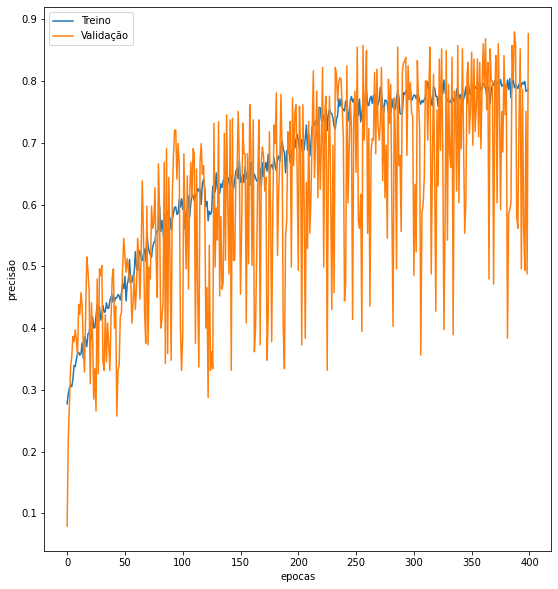

In [ ]:
#Visualizando os resultados do treinamento.
from matplotlib import pyplot as plt

his = resultado.history

plt.figure(1,figsize=(20,10))
plt.subplot(122)
plt.ylabel('precisão')
plt.xlabel('epocas')
plt.plot(his[f'acc'], label='Treino')
plt.plot(his[f'val_acc'], label='Validação')
plt.legend()
plt.show()

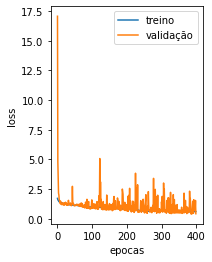

In [ ]:
#Erro por epoca.
plt.subplot(122)
plt.xlabel('epocas')
plt.ylabel('loss')
plt.plot(his['loss'], label='treino')
plt.plot(his['val_loss'], label='validação')
plt.legend()
plt.show()

Acertos: 87.67123287671232 %.

0.97
0.65
0.98
0.98
Acertos total (Media):0.89


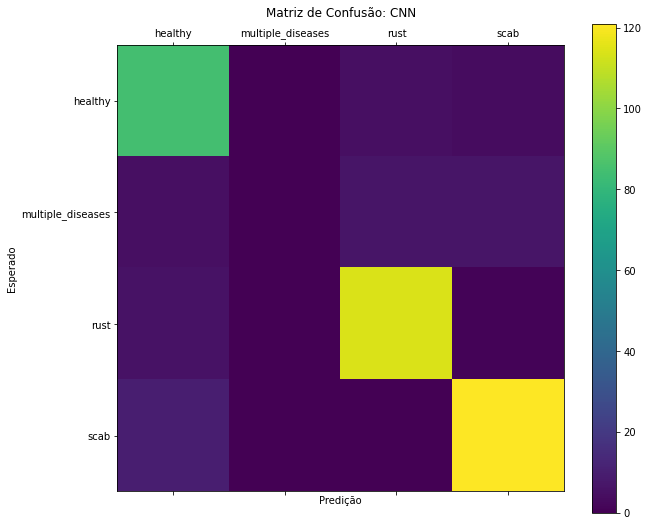

In [ ]:
#Matriz de confusão + Teste ROC AUC.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.colors

predicao = modelo.predict(x_teste)

y_pred = np.array([])
for i in predicao:
  y_pred = np.append(y_pred,np.argmax(i))

y_verdade = np.array([])
for i in y_teste:
  y_verdade = np.append(y_verdade,np.argmax(i))

acertos = 0
for i in range(y_verdade.shape[0]):
  if y_verdade[i] == y_pred[i]:
    acertos += 1
print('Acertos:', ((acertos/y_verdade.shape[0])*100), '%.\n')

acertos = 0
for i in range(4):
    score = roc_auc_score(y_teste[:, i], predicao[:, i])
    acertos += score
    print(f'{score:.2f}')

acertos /= 4
print(f'Acertos total (Media):{acertos:.2f}')

c_m = confusion_matrix(y_verdade, y_pred)

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

figura = plt.figure(figsize=(10,9))
axis = figura.add_subplot(111)
caxis = axis.matshow(c_m)
plt.title('Matriz de Confusão: CNN')
figura.colorbar(caxis)
plt.xticks([0,1,2,3],labels)
plt.yticks([0,1,2,3],labels)
plt.xlabel('Predição')
plt.ylabel('Esperado')
plt.show()

In [ ]:
'''
Anotações:
EX1: Primeiro teste: adicionado regularizadores nas camadas -> Evitar overfitting. (Mesma rede do baseline que obteve 79% de precisão.) -> Tempo de execução: 2,8 h
EX2: Segundo teste: adicionado callbacks, early stopping, reducing -> Controlar o overfitting. (Mesma rede do baseline que obteve 79% de precisão.) -> Tempo de execução: 1,53 h
'''

In [ ]:
''' Modelo Final '''

modelo = tf.keras.models.Sequential()

modelo.add(tf.keras.layers.Conv2D(32,3,input_shape=(255,255,3),kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
modelo.add(tf.keras.layers.LeakyReLU())
modelo.add(tf.keras.layers.Conv2D(16,5,kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
modelo.add(tf.keras.layers.LeakyReLU())
modelo.add(tf.keras.layers.MaxPooling2D())
modelo.add(tf.keras.layers.Dropout(0.5))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Flatten())
modelo.add(tf.keras.layers.Dense(16, activation='relu'))
modelo.add(tf.keras.layers.Dropout(0.5))
modelo.add(tf.keras.layers.BatchNormalization())
modelo.add(tf.keras.layers.Dense(4, activation='softmax'))

modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 253, 253, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 249, 249, 16)      12816     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 249, 249, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 124, 124, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 16)      6

In [ ]:
#Treinamento

early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('modelo.hdf5', save_best_only=True)
reducao_reg = tf.keras.callbacks.ReduceLROnPlateau(patience=20)

modelo.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True)
resultado = modelo.fit(data_aug.flow(x_treino,y_treino,batch_size=100),epochs=400,steps_per_epoch=x_treino.shape[0]//100, verbose=0,callbacks=[early_stopping, checkpoint, reducao_reg],validation_data=(x_teste,y_teste))
modelo = tf.keras.models.load_model('modelo.hdf5')
print('Feito.\n')

Feito.



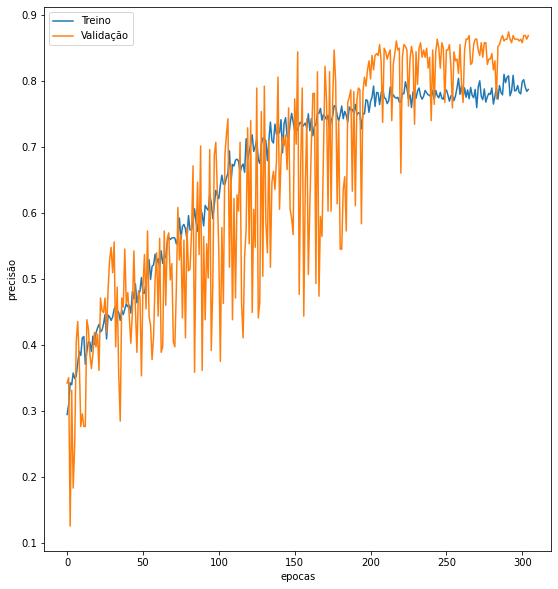

In [ ]:
#Visualizando os resultados do treinamento.
from matplotlib import pyplot as plt

his = resultado.history

plt.figure(1,figsize=(20,10))
plt.subplot(122)
plt.ylabel('precisão')
plt.xlabel('epocas')
plt.plot(his[f'acc'], label='Treino')
plt.plot(his[f'val_acc'], label='Validação')
plt.legend()
plt.show()

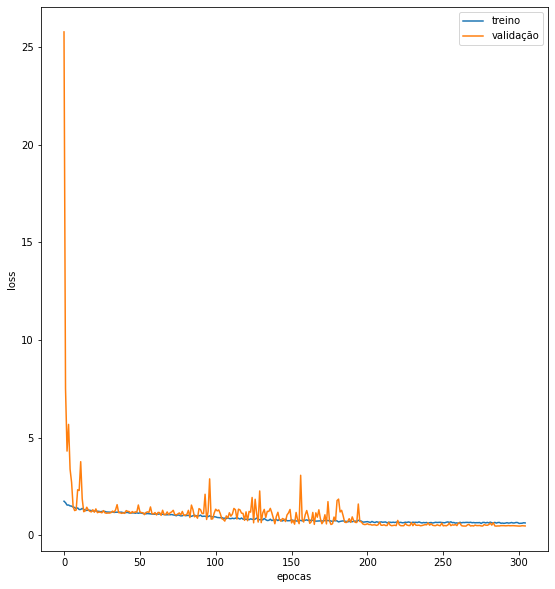

In [ ]:
#Erro por epoca.
plt.figure(1,figsize=(20,10))
plt.subplot(122)
plt.xlabel('epocas')
plt.ylabel('loss')
plt.plot(his['loss'], label='treino')
plt.plot(his['val_loss'], label='validação')
plt.legend()
plt.show()

Acertos: 86.3013698630137 %.

0.97
0.69
0.97
0.98
Acertos total (Media):0.90


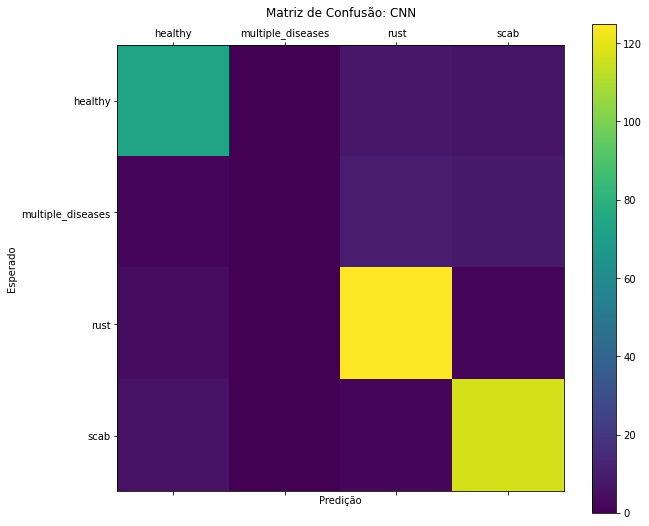

In [ ]:
#Matriz de confusão + Teste ROC AUC.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.colors

predicao = modelo.predict(x_teste)

y_pred = np.array([])
for i in predicao:
  y_pred = np.append(y_pred,np.argmax(i))

y_verdade = np.array([])
for i in y_teste:
  y_verdade = np.append(y_verdade,np.argmax(i))

acertos = 0
for i in range(y_verdade.shape[0]):
  if y_verdade[i] == y_pred[i]:
    acertos += 1
print('Acertos:', ((acertos/y_verdade.shape[0])*100), '%.\n')

acertos = 0
for i in range(4):
    score = roc_auc_score(y_teste[:, i], predicao[:, i])
    acertos += score
    print(f'{score:.2f}')

acertos /= 4
print(f'Acertos total (Media):{acertos:.2f}')

c_m = confusion_matrix(y_verdade, y_pred)

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

figura = plt.figure(figsize=(10,9))
axis = figura.add_subplot(111)
caxis = axis.matshow(c_m)
plt.title('Matriz de Confusão: CNN')
figura.colorbar(caxis)
plt.xticks([0,1,2,3],labels)
plt.yticks([0,1,2,3],labels)
plt.xlabel('Predição')
plt.ylabel('Esperado')
plt.show()

In [ ]:
'''Segundo Modelo de Rede Neural
1º Execução => DenseNet.
'''

In [ ]:
modelo = tf.keras.models.Sequential([tf.keras.applications.DenseNet121(input_shape=(255, 255, 3), weights='imagenet', include_top=False), tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(y_treino.shape[1], activation='softmax')])

modelo.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
#Treinamento

early_stopping = tf.keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('modelo.hdf5', save_best_only=True)
reducao_reg = tf.keras.callbacks.ReduceLROnPlateau(patience=20)

modelo.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True)
resultado = modelo.fit(data_aug.flow(x_treino,y_treino, batch_size=64),epochs=400,steps_per_epoch=x_treino.shape[0]//64, verbose=0,callbacks=[early_stopping, checkpoint, reducao_reg],validation_data=(x_teste,y_teste))
modelo = tf.keras.models.load_model('modelo.hdf5')
print('Feito.\n')

Feito.



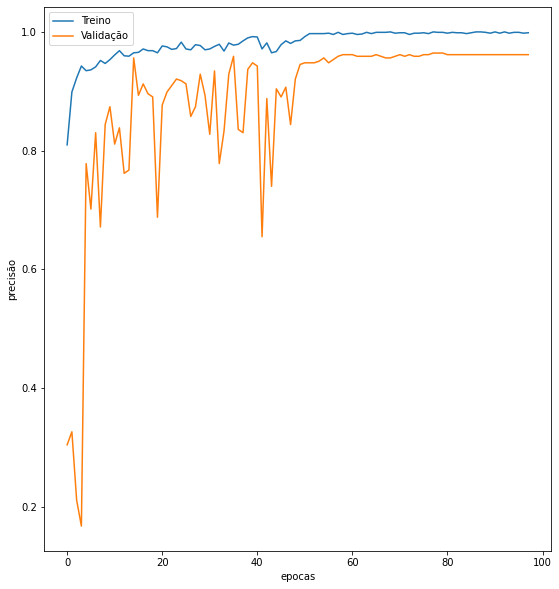

In [ ]:
#Visualizando os resultados do treinamento.
from matplotlib import pyplot as plt

his = resultado.history

plt.figure(1,figsize=(20,10))
plt.subplot(122)
plt.ylabel('precisão')
plt.xlabel('epocas')
plt.plot(his[f'acc'], label='Treino')
plt.plot(his[f'val_acc'], label='Validação')
plt.legend()
plt.show()

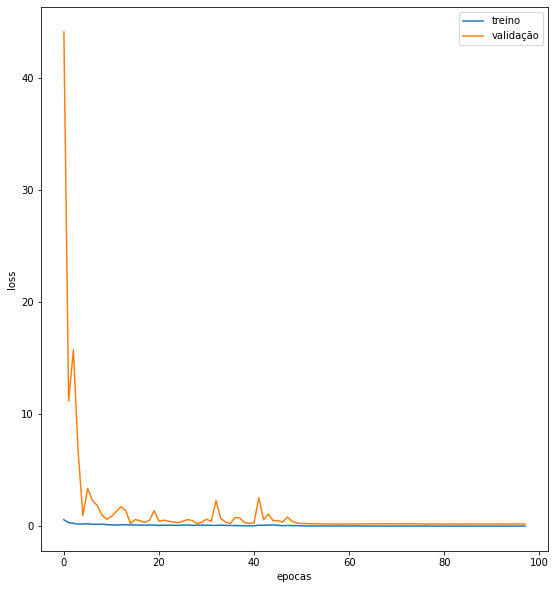

In [ ]:
#Erro por epoca.
plt.figure(1,figsize=(20,10))
plt.subplot(122)
plt.xlabel('epocas')
plt.ylabel('loss')
plt.plot(his['loss'], label='treino')
plt.plot(his['val_loss'], label='validação')
plt.legend()
plt.show()

Acertos: 95.8904109589041 %.

1.00
0.90
1.00
0.99
Acertos total (Media):0.97


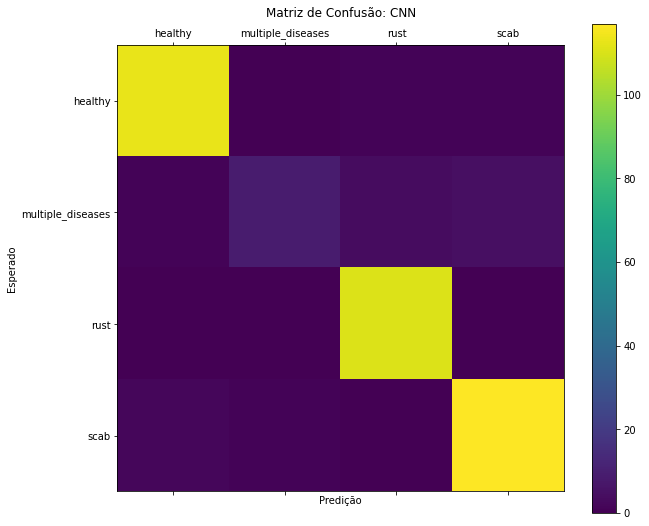

In [ ]:
#Matriz de confusão + Teste ROC AUC.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.colors

predicao = modelo.predict(x_teste)

y_pred = np.array([])
for i in predicao:
  y_pred = np.append(y_pred,np.argmax(i))

y_verdade = np.array([])
for i in y_teste:
  y_verdade = np.append(y_verdade,np.argmax(i))

acertos = 0
for i in range(y_verdade.shape[0]):
  if y_verdade[i] == y_pred[i]:
    acertos += 1
print('Acertos:', ((acertos/y_verdade.shape[0])*100), '%.\n')

acertos = 0
for i in range(4):
    score = roc_auc_score(y_teste[:, i], predicao[:, i])
    acertos += score
    print(f'{score:.2f}')

acertos /= 4
print(f'Acertos total (Media):{acertos:.2f}')

c_m = confusion_matrix(y_verdade, y_pred)

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']

figura = plt.figure(figsize=(10,9))
axis = figura.add_subplot(111)
caxis = axis.matshow(c_m)
plt.title('Matriz de Confusão: CNN')
figura.colorbar(caxis)
plt.xticks([0,1,2,3],labels)
plt.yticks([0,1,2,3],labels)
plt.xlabel('Predição')
plt.ylabel('Esperado')
plt.show()

In [ ]:
#Predição com as imagens de validação

predicao_teste = modelo.predict(imagem_teste)

resposta = pd.DataFrame()
resposta['image_id'] = img_id_teste
resposta['healthy'] = predicao_teste[:, 0]
resposta['multiple_diseases'] = predicao_teste[:, 1]
resposta['rust'] = predicao_teste[:, 2]
resposta['scab'] = predicao_teste[:, 3]
resposta.to_csv('/content/drive/MyDrive/Colab/sub.csv', index=False)